This is the midterm assignment of the Machine Learning Course Move37. 
Augmented Random Search was chosen to make the Open AI Bipedal Walker walk. 
However, the Agent is general. It could be used for other gym environments as well without change. But probably hyper paramter would require adaptation. 
Requires:
openai gym (pip install gym)
swig.exe : http://www.swig.org/  (add path)
ffmpeg : https://www.ffmpeg.org/download.html (add path)
box2d (pip install box2d-py)
written in python 3.6.7 using a jupyter server in VS Code

In [1]:
import numpy as np
import gym
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

class Agent():
    """
    Agent Class: This encapsules a  Agent learning by Augmented Random Serach in accorance to: https://arxiv.org/pdf/1803.07055.pdf
    Class contains everything that is required to return an action given a state using a policy. 
    But also update the policy (weights) given rewards.
    Training and exploration is run outside the Class and interact only via
    states and returns with methods of this class.
    Methods:
        :__init__: Set parameter but also the policy (weights) and other instance variables to initial state
        :Normalize: Normalize state but also update after each training call. See algorithm
        :UpdateWeights: Update the weights (aka learning). 
        :GetAction: Return an action - optionally with a noise matrix included for learning
        :SaveWeights: saves agent perceptron and setting to disk
        :LoadWeights: loads agent perceptron and settings from disk
    """
    def __init__(self,hp_dict):
        self.hp_dict = hp_dict
        self.weights = np.zeros((self.hp_dict["action_space"],self.hp_dict["observation_space"]))
        self.mean = np.zeros(self.hp_dict["observation_space"])
        self.mean_diff = np.zeros(self.hp_dict["observation_space"])
        self.var = np.zeros(self.hp_dict["observation_space"])
        self.N = np.zeros(self.hp_dict["observation_space"]) 


    def Normalize(self,state,delta = None):
        """ 
        Function for Normalization.
        This needs to be part of the agent as the calculation of the mean and vaiance requires informations
        like how often training was called.
        Args: 
           :state: the state to normalize
           :delta: if this is a normalizaiton for testing not learning, delta will be None and no update on mean will be perfomred
        Return: normalized state
        """
        #update mean only if delta is not none (training play insead of just play)
        if delta is not None:
            self.N += 1
            last_mean = self.mean.copy()
            self.mean += (state-self.mean) / self.N
            self.mean_diff += (state-last_mean) * (state-self.mean)
            self.var = (self.mean_diff / self.N).clip(min = 0.001)
        #return normalized
        return (state-self.mean) / np.sqrt(self.var)


    def UpdateWeights(self,rollouts):
        """ 
        Function for updateing the weights based on the positive and negative returns form the rollouts.
        Algorithm accoring to https://arxiv.org/pdf/1803.07055.pdf
        Args: :rollouts: list of tuples (reward_pos,reward_neg,delta).
        Return: None
        """
        #calculate stddev of sum of all positive and negaive rewards. This is position 0 and 1.
        stddev_rewards = np.std([rollout[0]+rollout[1] for rollout in rollouts])
        curr_diff_matrix = np.zeros(self.weights.shape)
        for reward_positive,reward_negative,delta in rollouts:
            curr_diff_matrix += (reward_positive - reward_negative) * delta
            self.weights += self.hp_dict["learning_rate"] / (len(rollouts) * stddev_rewards) * curr_diff_matrix


    def GetAction(self,state,direction=None,delta=None):
        """ 
        Returns an action. Either with a direction (for training) or without (for testing)
        Args: 
           :state: the state array
           :direction: 1,-1 
           :delta: a delta matrix the same dimension as self.states
        Return: the dot product of the weigts with the state, optionally with delta added or substracted form weights.
        """
        if direction == None:
            return self.weights.dot(state)
        elif direction == 1:
            return (self.weights + self.hp_dict["noise_magnitude"]*delta).dot(state)
        elif direction == -1:
            return (self.weights - self.hp_dict["noise_magnitude"]*delta).dot(state)
    

    def SaveWeights(self,filename=None):
        """ 
        Function for saving the weights and the self.hp_dict to disk
        Args: :filename: optionally a filename as string. appendix will be added automatically
        """
        if filename == None:
            filename = self.hp_dict["game"]
        try:
            np.save(filename + "_weight.npy",self.weights)
            np.save(filename + "_hp_dict.npy",self.weights)
            print(f"Saved to: {filename}")
        except:
            print(f"Failed to save file: {filename}")

    
    def LoadWeights(self,filename=None):
        """ 
        Function for loading the weights and the self.hp_dict from disk
        Args: :filename: optionally a filename as string. appendix will be added automatically
        """
        if filename == None:
            filename = self.hp_dict["game"]
        try:
            self.weights = np.load(filename + "_weight.npy")
            self.hp_dict = np.load(filename + "_hp_dict.npy")
            print(f"Loaded from: {filename}")
        except:
            print(f"Failed to load file: {filename}")

From here on just some function defintions for training, playing and generating rollouts and plotting results.
The agent is relativly self-contained

In [2]:
def Play(agent,env,direction=None,delta=None):
    """ 
    Play a game till it returns done=True or max episode_length is reachen
    Args: 
       :agent: the agent object
       :env: the environment (open ai gym)
       :direction: required for training, see Rollout fuction for call
       :delta: also required for training, see Rollout function for call
    Return: sum of all rewards
    """
    #print(f"playing a game. Direction={direction}")
    sum_rewards = 0
    done = False
    i=0
    state = env.reset()
    #play using the usual SARS' loop, sum the rewards.
    while not done and i <= agent.hp_dict["episode_length"]:
        state = agent.Normalize(state,delta)
        action = agent.GetAction(state,direction,delta)
        state, reward, done, _ = env.step(action)
        reward = np.clip(reward,-1,1)
        sum_rewards += reward
        i += 1
    return sum_rewards


def Rollouts(agent,env,n_rollouts):
    """ 
    Main fuctionality of the training algorithem happens here.
    n_rollouts are generated, each with a positive and a negative random matrix substracted from the agent weights.
    Results are generated. Everything is put into a list, sorted and returned.
    Args: 
        :agent: the agent object
        :env: the envionment object (open ai gym)
        :n_rollouts: number of rollouts
    Return: list of tuples (reward_positive,reward_negative), sorted and cut by the hyper parameter take_best_parallel_deltas
    """
    #print(f"generating {n_rollouts} rollouts for this epoch.")
    rollouts = []
    sort_lst = []
    for i in range(n_rollouts):
        #generate delta matrix
        delta = np.random.randn(agent.hp_dict["action_space"],agent.hp_dict["observation_space"])
        #play two games, one with positive and one with negative delta
        reward_positive = Play(agent,env,direction=1,delta=delta)
        reward_negative = Play(agent,env,direction=-1,delta=delta)
        #append results. 
        rollouts.append((reward_positive,reward_negative,delta))
        #additonal list to be able to sort. Writing index and max(pos_rew,neg_rew).
        sort_lst.append([i,max(reward_positive,reward_negative)])
    #sort and the the n best.
    sort_lst = sorted(sort_lst,key = lambda x: x[1],reverse = True)[:agent.hp_dict["take_best_parallel_deltas"]]
    #return a list generated from the sorted indices
    return [rollouts[i] for i,k in sort_lst]
    

def Live_plot(data,figsize=(7,5),title='Reward'):
    """ 
    A simple "dynamic" pyplot for showing the rewards during training.
    Args: 
       :data: the data to plot (simple 1d list)
    """
    clear_output(wait=True)
    plt.figure(figsize = figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.show()


def Train(agent,env):
    """ 
    All training of the agent object takes place here.
    Basically, it just generates rollouts and then updates the weights in the agent object many times.
    Args: 
       :agent: the agent object
       :env: the envionment object (open ai gym)
    Return: the trained agent object
    """
    rec_now = False
    result_list = []
    #create the enviroment with the video wrapper around it. Video_callable need to be a function.
    env = gym.wrappers.Monitor(env,agent.hp_dict["video_path"], video_callable=lambda x:rec_now, force=True)
    for epoch in range(agent.hp_dict["epochs"]):
        rec_now = False
        #generate rollouts:
        rollouts = Rollouts(agent,env,agent.hp_dict["parallel_deltas"])
        #use the best of these (or all) to update weights of agent:
        agent.UpdateWeights(rollouts)
        #record every n epoch:
        if epoch % agent.hp_dict["record_every"] == 0: rec_now = True         
        #print(f"epoch: {epoch}   avg reward: {Play(agent,env)}")
        result_list.append(Play(agent,env))
        Live_plot(result_list)
        #save agent to disk if 300 is hit
        if result_list[-1] == 300:
            agent.SaveWeights('success_'+str(epoch))
    return agent

Main call.
1) Define the dict. 
2) Generate environment. 
3) Create Agent. 
4) Start training. 
5) Get coffee.
6) Save weights. 

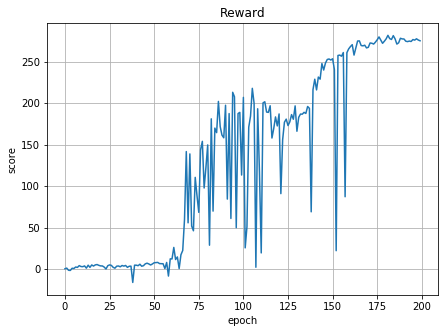

Saved to: test


In [3]:
hp_dict = {
    "game" : "BipedalWalker-v2",
    "video_path" : "videos",
    "record_every" : 10,
    "epochs" : 200,
    "episode_length" : 4000,
    "learning_rate" : 0.01,
    "noise_magnitude" : 0.03,
    "parallel_deltas" : 16,
    "take_best_parallel_deltas" : 16
}

env = gym.make(hp_dict["game"])
#add observation space and action space to hp_dict becuase agent will need it.
hp_dict["observation_space"] = env.observation_space.shape[0]
hp_dict["action_space"] = env.action_space.shape[0]
#make an agent object
agent = Agent(hp_dict)
#train agent
agent = Train(agent,env)
#save weights and hp_dict
agent.SaveWeights("test")

The agent trains well and generates reasonable results after 200 epochs already. 

In [9]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="videos/openaigym.video.0.940.video006302.mp4" type="video/mp4">
</video>
""")